In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from numba import njit,prange
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from commonfunctions import *



In [2]:
%%capture
%run  letters_extraction.ipynb

In [3]:
directory = './symbols/'

<h3>Reading directory names</h3>

In [4]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['!', '( - Copy', ')', '+', '+_copy', '0 - Copy', '1', '=', 'A', 'B', 'C', 'F', 'M', 'N', 'z']
15


<h4>Getting a list of unique file extensions</h4>

In [5]:
extensions = []

for path, subdirs, files in os.walk(directory):
        for name in files:
            if os.path.splitext(name)[1] not in extensions:
                extensions += [os.path.splitext(name)[1]]

print(extensions)
sorted(os.listdir(directory))

['.jpg', '.png', '.jpeg']


['!',
 '( - Copy',
 ')',
 '+',
 '+_copy',
 '0 - Copy',
 '1',
 '=',
 'A',
 'B',
 'C',
 'F',
 'M',
 'N',
 'z']

<h3>Map unique strings to integers in Python. Make dictionary</h3>

In [6]:
from collections import defaultdict
d = defaultdict(int)
co = 0
for x in sorted(os.listdir(directory)):
    if not d[x]:
        d[x] = co
        co+=1
d

defaultdict(int,
            {'!': 0,
             '( - Copy': 1,
             ')': 2,
             '+': 3,
             '+_copy': 4,
             '0 - Copy': 5,
             '1': 6,
             '=': 7,
             'A': 8,
             'B': 9,
             'C': 10,
             'F': 11,
             'M': 12,
             'N': 13,
             'z': 14})

<h3>Resizing images</h3>

In [7]:
from skimage.morphology import skeletonize
def prepare_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = get_letters(image, single_letter=True)[0]
    return image

def images_resize(directory):
    list_target_names = []
    list_images = []
        
    for path, subdirs, files in os.walk(directory):
        files = [f for f in files if not f[0] == '.'] # Ignore '.directory' file
        # subdirs[:] = [d for d in subdirs if not d[0] == '.'] # Ignore hidden directories
        print(path, len(files))
        limit = 1000
        if len(files) > limit:
            files = files[:limit]
            
        for name in files:
            image=cv2.imread(os.path.join(path, name))
            image = prepare_image(image)
            # image=cv2.resize(image, (100, 100))
            list_target_names.append(os.path.basename(path))
            list_images.append(image)
    
    return list_target_names,  list_images 
        
target_names,images = images_resize(directory)

./symbols/ 0
./symbols/! 1300
./symbols/( - Copy 14294
./symbols/) 14355
./symbols/+ 25112
./symbols/+_copy 25112
./symbols/0 - Copy 7509
./symbols/1 27082
./symbols/= 1397
./symbols/A 2455
./symbols/B 2400
./symbols/C 5857
./symbols/F 3767
./symbols/M 2476
./symbols/N 10862
./symbols/z 5870


In [8]:
len(target_names)

15000

In [9]:
len(images)

15000

In [10]:
from collections import Counter
c = Counter(sorted(target_names))

c

Counter({'!': 1000,
         '( - Copy': 1000,
         ')': 1000,
         '+': 1000,
         '+_copy': 1000,
         '0 - Copy': 1000,
         '1': 1000,
         '=': 1000,
         'A': 1000,
         'B': 1000,
         'C': 1000,
         'F': 1000,
         'M': 1000,
         'N': 1000,
         'z': 1000})

<h3>Assign a Dictionary Value to the List <B><I>"target_names"</I></B> Based on Dictionary Key</h3>

In [11]:
target_names = [d[key] for key in target_names]

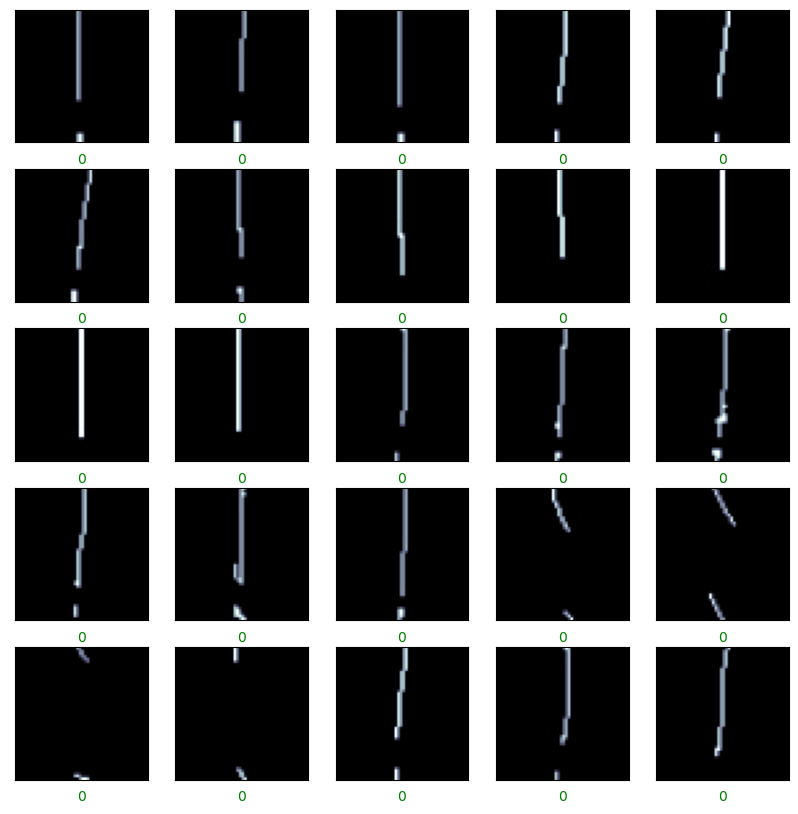

In [12]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=target_names[i])
    axi.xaxis.label.set_color('green')

<h4>Randomly shuffle two lists "target_names" and "images" keeping initial order</h4>

In [13]:
# target_names_shuffled, images_shuffled = shuffle(np.array(target_names, dtype=object), np.array(images, dtype=object))
target_names_shuffled, images_shuffled = shuffle(np.array(target_names), np.array(images))

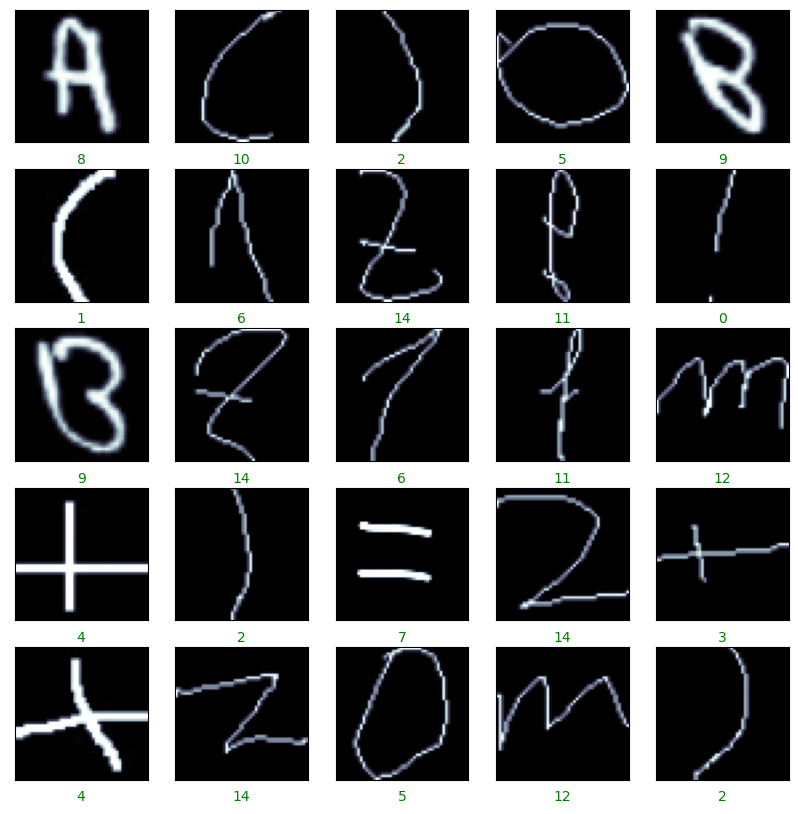

In [14]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(images_shuffled[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names_shuffled[i])
    axi.xaxis.label.set_color('green')

<h4>Reshaping dataframe</h4>

In [15]:
n_samples,nx,ny= images_shuffled.shape
images_shuffled = images_shuffled.reshape(n_samples, nx*ny)
images_shuffled.shape

(15000, 2500)

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images_shuffled, target_names_shuffled, random_state=0)

In [17]:
# import numpy as np
# from joblib import parallel_backend # added line.
# from sklearn.datasets import load_digits
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC      
# from sklearn.ensemble import RandomForestClassifier
# from ray.util.joblib import register_ray # added line.
# register_ray() # added line.

# param_space = {
#     'C': np.logspace(-6, 6, 30),
#     'gamma': np.logspace(-8, 8, 30),
#     'tol': np.logspace(-4, -1, 30),
#     'class_weight': [None, 'balanced'],
# }

# model = RandomForestClassifier(n_estimators=1000)
# search = RandomizedSearchCV(model, param_space, cv=5, n_iter=300,verbose=1)
# # digits = load_digits()
# ray.init(address='auto')
# with parallel_backend('ray'): # added line.
#     search.fit(Xtrain, ytrain)
    
# ypred = search.predict(Xtest)


<h3>Implementing an Random Forest Classifier</h3>

In [18]:
# from sklearnex import patch_sklearn
import joblib
# patch_sklearn()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(Xtrain, ytrain)
# ypred = clf.predict(Xtest)
# from sklearn import svm
# model = svm.SVC(gamma = 0.001, C =100)
# model.fit(Xtrain, ytrain)
# ypred = model.predict(Xtest)

 
# import pickle
# s = pickle.dumps(model)


In [19]:
import joblib

# save the model to disk
filename = './saved_models/finalized_model.sav'
joblib.dump(model, filename)
 

['./saved_models/finalized_model.sav']

<h3>The classification report for this classifier:</h3>

In [20]:
from sklearn import metrics
print(Xtest.shape)
print(metrics.classification_report(ytest, ypred))
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

(3750, 2500)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       273
           1       1.00      1.00      1.00       231
           2       0.95      0.97      0.96       256
           3       0.96      0.92      0.94       259
           4       1.00      0.99      1.00       252
           5       0.92      0.95      0.93       255
           6       0.92      0.89      0.90       246
           7       0.93      0.96      0.95       211
           8       0.99      0.99      0.99       268
           9       0.99      0.98      0.99       255
          10       0.99      0.94      0.96       247
          11       0.94      0.98      0.96       243
          12       0.91      0.96      0.94       266
          13       0.94      0.89      0.91       245
          14       1.00      1.00      1.00       243

    accuracy                           0.96      3750
   macro avg       0.96      0.96      0.96      3750
weighted avg 

<h3>Plot the confusion matrix:</h3>

Text(273.99999999999994, 0.5, 'predicted label')

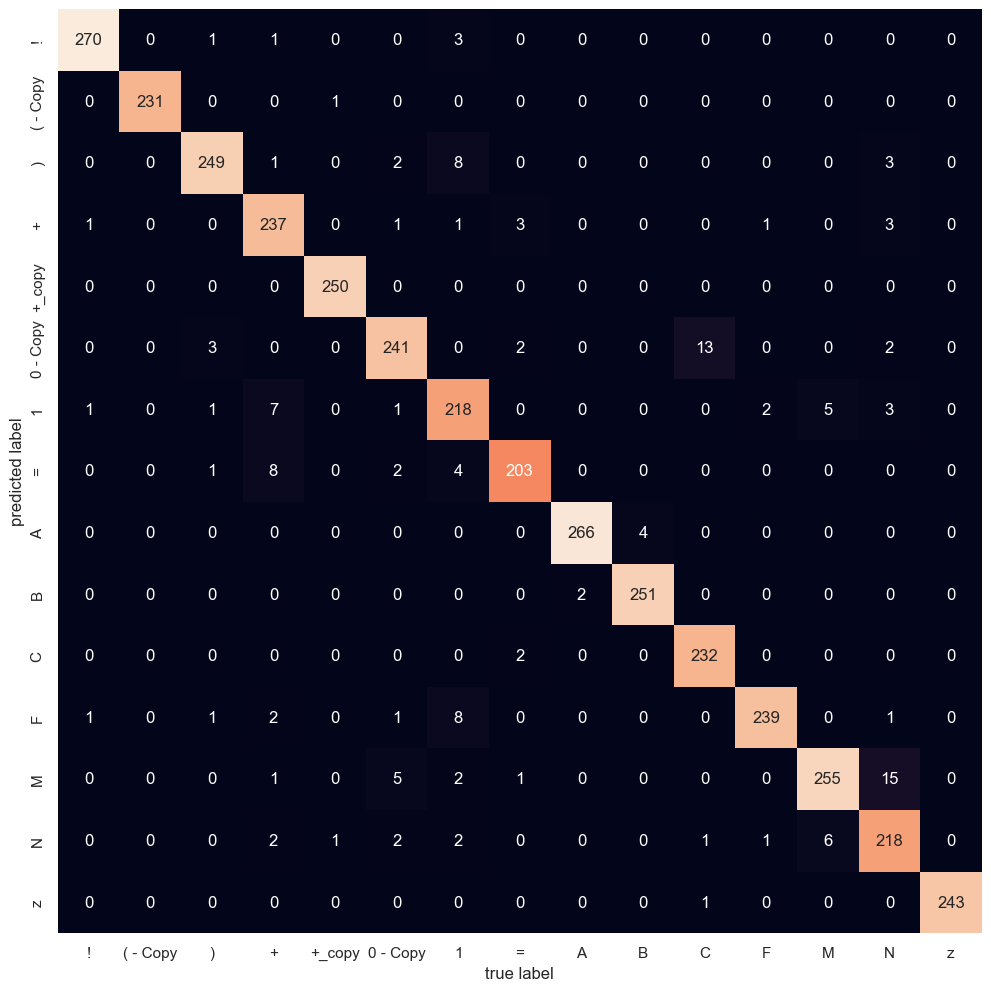

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=list(d.keys()), yticklabels=list(d.keys()))


plt.xlabel('true label')
plt.ylabel('predicted label')


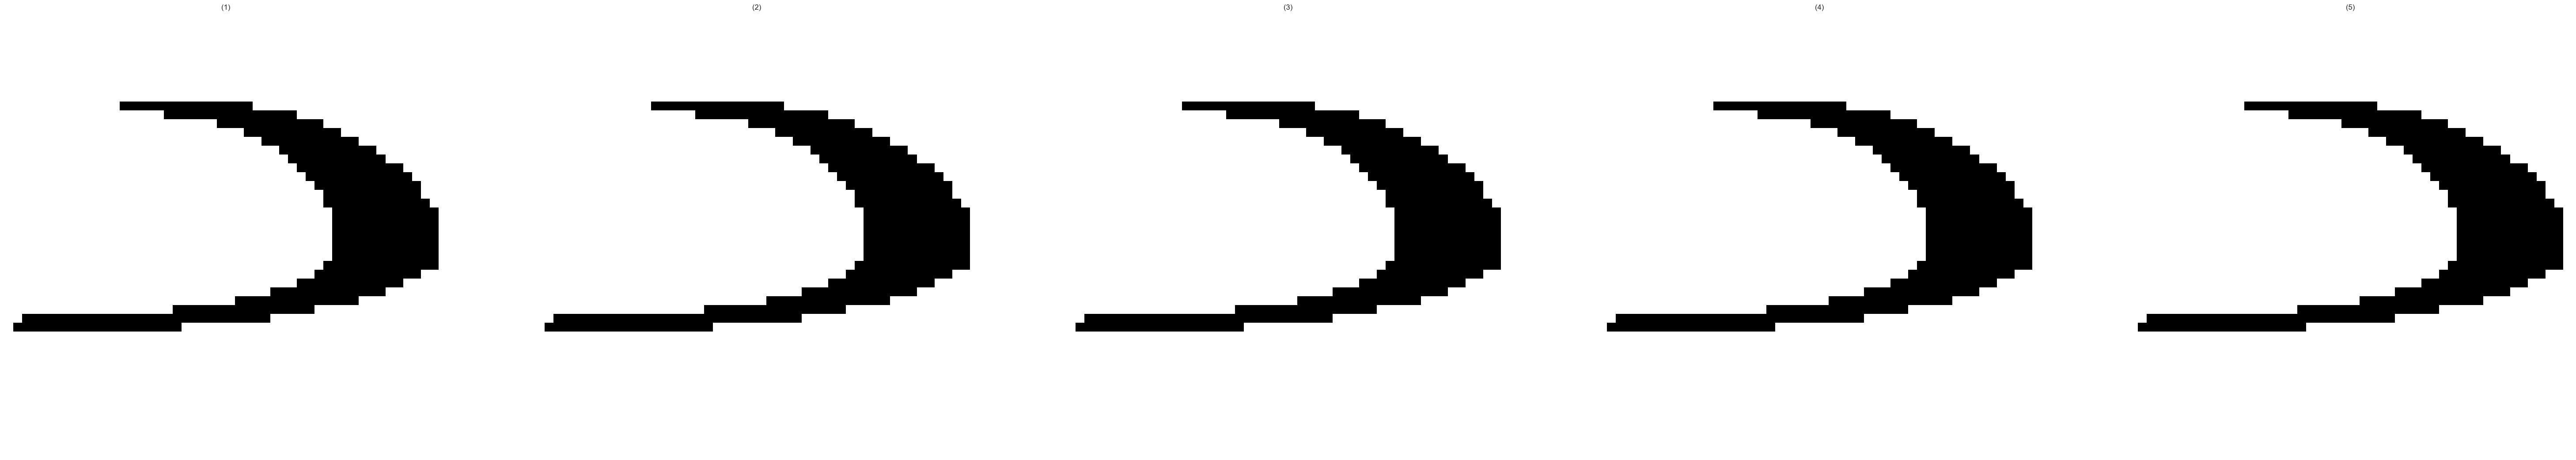

(5, 2500)
[9 9 9 9 9]
['B', 'B', 'B', 'B', 'B']
['B', 'B', 'B', 'B', 'B']


In [44]:
letters= cv2.cvtColor(cv2.imread('./test_images/classification/).png'), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False, show_trace= False))
letters_res = 255-letters_res
show_images(letters_res)
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False)[0]])

letters_res = letters_res.reshape(len(letters_res), -1)

print(letters_res.shape)

results = model.predict(letters_res)
print(results)
print([list(d.keys())[i] for i in results])
inv_map = {v: k for k, v in d.items()}
print([inv_map[i] for i in results])


In [23]:
# letters= cv2.cvtColor(cv2.imread(r'D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\symbol2\9\0ZGdgPTM.png'), cv2.COLOR_BGR2GRAY)
# letters_res = np.array(get_letters(letters, single_letter=True, show_trace=True))
# cf.show_images([letters_res[0], get_letters(letters, single_letter=False,show_trace=True)[0]])

In [24]:

# import os
# import cv2
# import numpy as np

# # invert and rotate all the images in the B directory 
# # to make them look like the images in the A directory
# def invert_and_rotate_images(path):
#     for filename in os.listdir(path):
#         img = cv2.imread(os.path.join(path,filename))
#         img = cv2.bitwise_not(img)
#         img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#         cv2.imwrite(os.path.join(path+'/inv/',filename), img)

# invert_and_rotate_images(r"D:\academic_material\third_year\imageProcessing\repos\LogIm\phase_1\datasets\emnist\EMNIST\A")


In [25]:
import joblib

model = joblib.load('./saved_models/finalized_model.sav')

img shape: (464, 1557), max=255, min=0,median=255.0 and type uint8


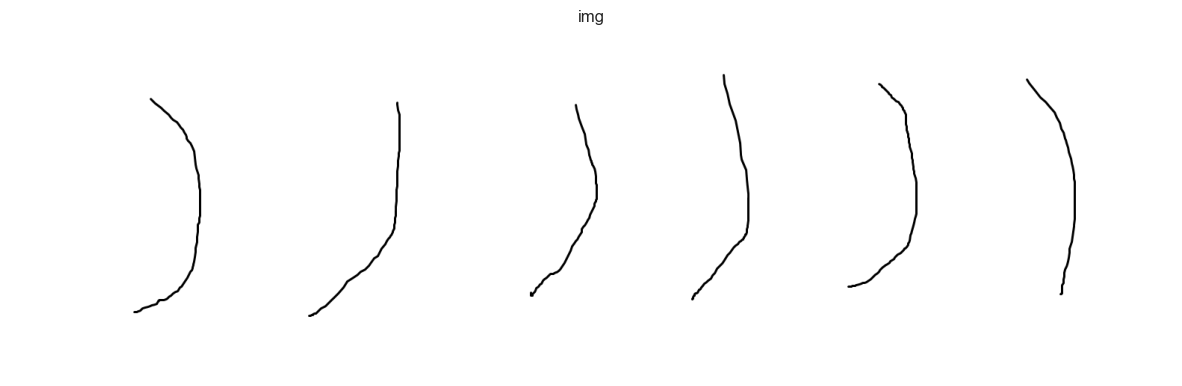

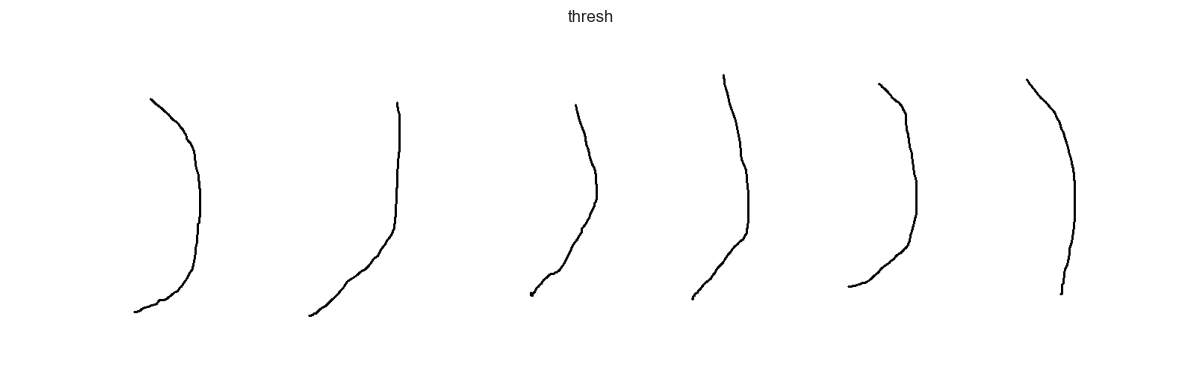

contours before area filtering
1192.0, 1347.0, 1423.5, 1341.0, 1231.0, 1336.0, -720428.0, 
contours after area filtering
1192.0, 1347.0, 1423.5, 1341.0, 1231.0, 1336.0, 
masks


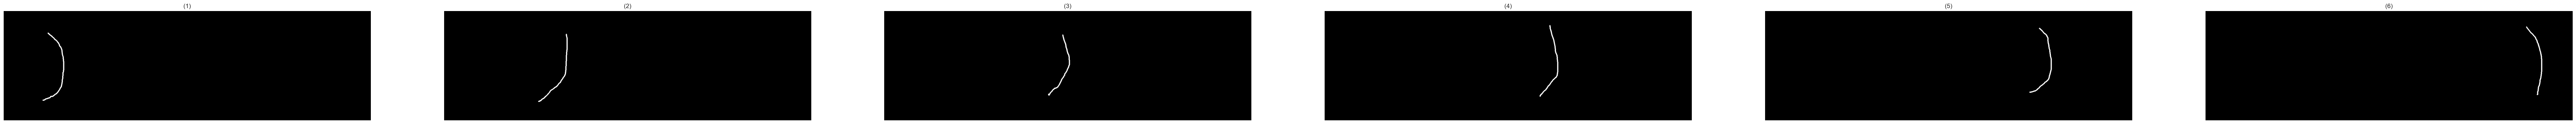

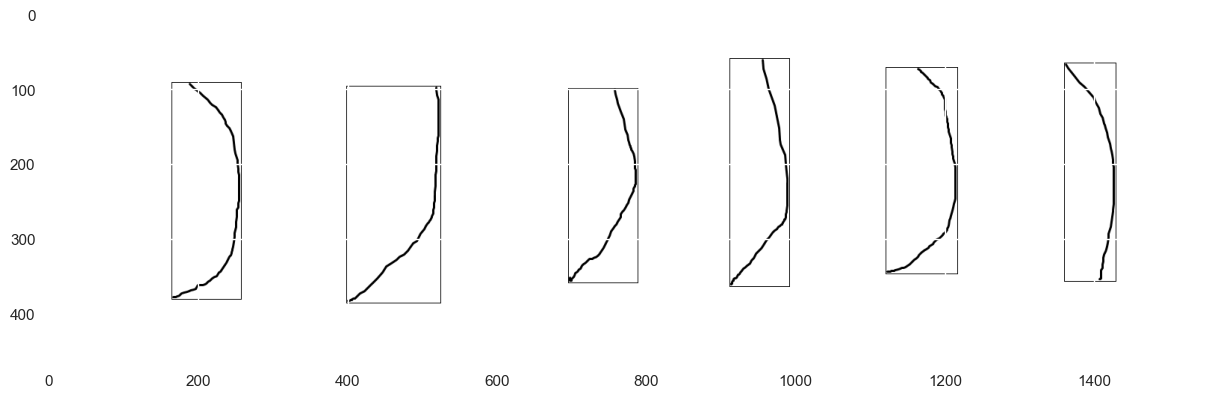

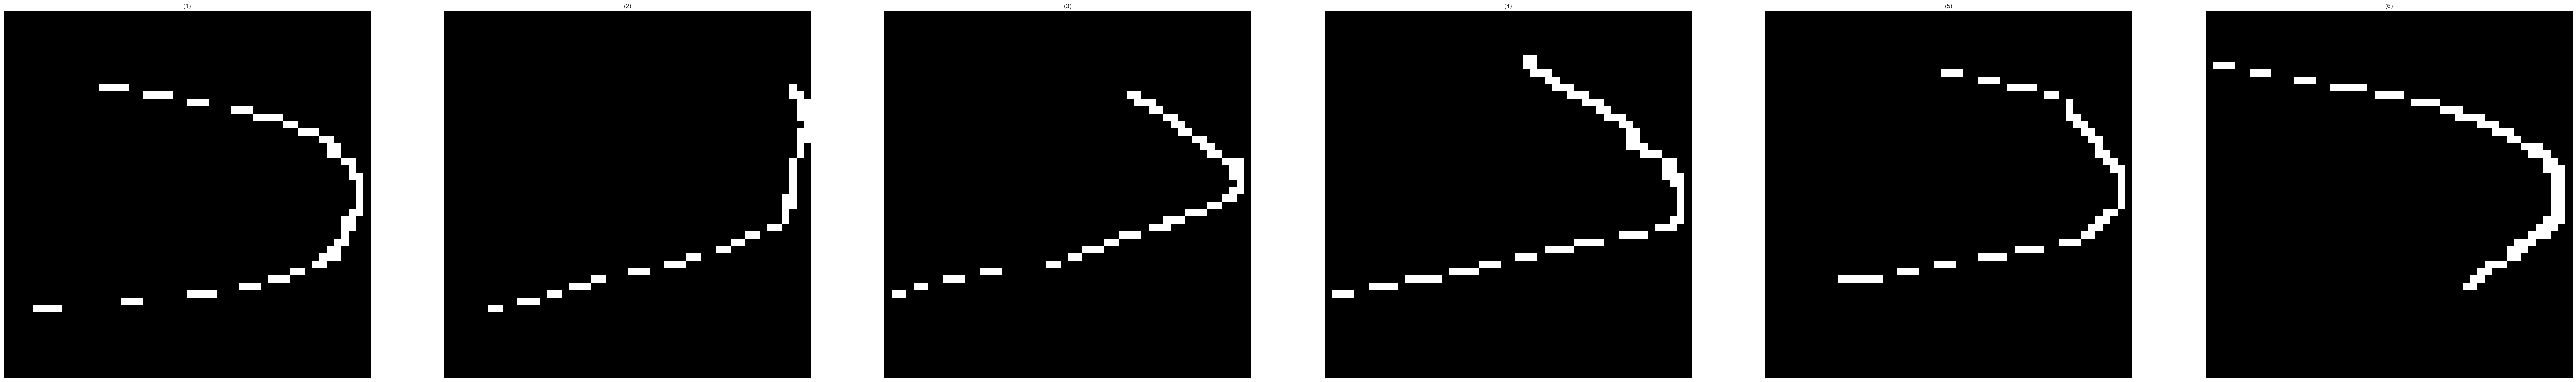

results
[7 7 7 7 7 7]


In [45]:
letters= cv2.cvtColor(cv2.imread(r"D:\CMP #3\Image Processing\Project\LogIm\phase_1\test_images\classification\6).png"), cv2.COLOR_BGR2GRAY)
letters_res = np.array(get_letters(letters, single_letter=False, show_trace=True))

letters_res = letters_res.reshape(len(letters_res), -1)

results = model.predict(letters_res)
print('results')
print(results)


